In [1]:
import logging

logger = logging.getLogger()
logger.handlers.clear()

# format
formatter = logging.Formatter('[%(asctime)s] [%(levelname)s] %(message)s')

# add stream handler
handler = logging.StreamHandler(sys.stdout)                             
handler.setFormatter(formatter)
logger.addHandler(handler)

# enable all logging level
logger.setLevel(logging.INFO)

Definition for the board.

In [2]:
from ece437.ok import OKFrontPanel

path = "C:\\ytliu2\\ECE437\\Lab9\\Lab9.runs\\impl_1\\lab9_top.bit"
path = None
fp = OKFrontPanel(firmware_path=path)

Start talking to CMV300.

In [3]:
from ece437.spi import SPIControllerEndpoints

SPI_ENDPOINTS = SPIControllerEndpoints(
    RESET = 0x00,
    DATA_IN = 0x01,
    DATA_OUT = 0x20,
    TRIGGER_IN = 0x40,
    TRIGGER_OUT = 0x60,

    RESET_MASK = 0,

    START_MASK = 0,
    MEM_RESET_MASK = 1,
    MEM_WRITE_MASK = 2,
    MEM_READ_MASK = 3,

    DONE_MASK = 0
)

Registers

In [4]:
n_lines = 488
t_exposure = 488 # in ticks
n_frames = 1

training_pattern = 0b1010101

register_values = {
    # number of lines
    1: n_lines & 0xFF,
    2: n_lines >> 8,

    # color
    #   0: color, 1: monochrome
    39: 1,

    # flipping
    #   0: no, 1: flip x, 2: flip y, 3: flip x/y
    40: 0,

    # exposure mode
    #   41[0]: 0: sequencer 42-44, 1: T_EXP1 and FRAME_REQ
    #   41[1]: 0: normal, 1: interleaved
    #41: 0,

    # exposure time
    #42: t_exposure & 0xFF,
    #43: t_exposure >> 8,
    #44: t_exposure >> 16,

    # number of frames
    55: n_frames & 0xFF,
    56: n_frames >> 8,

    # output mode
    #   0: 4 outputs (LVDS), 2: 2 outputs (LVDS), 3: 1 output (LVDS or CMOS)
    57: 3,

    # training pattern
    61: training_pattern & 0xFF,
    62: (training_pattern >> 8) & 0x0F,

    # test image
    #   0: normal, 1: fixed test image
    67: 1,

    # 8/10/12 mode
    #   0: 12, 1: 10, 2: 8
    68: 1,

    # clock out
    #   0: dval, 1: lval, 2: fval, 6: fot, 7: inte1, 8: inte2, 9: clk_out
    69: 9,

    # gain
    #   0-7: 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5
    80: 0,

    # power control
    #   81[6]: control
    #   81[5]: output clock
    #   81[4-3]: top data output
    #   81[2-1]: bottom data output
    #   81[0]: lvds clock input
    81: 0b1111110,

    # data rate
    #   155: 32-50 MHz, 187: 20-50 MHz, 251: 10-32 MHz
    83: 155,

    # adc gain
    #   100[6]: enable
    #   100[5-0]: gain
    100: (1 << 6) | 32
}

[2022-11-15 18:21:07,422] [INFO] reset SPI controller
serial=1911000P3V
-2


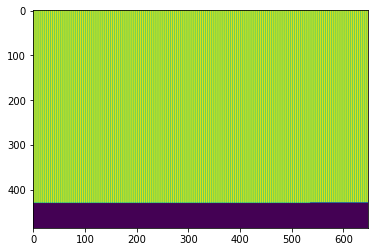

In [23]:
from ece437.spi import SPIController
import matplotlib.pyplot as plt
import numpy as np
import time

read_back = False

with fp, SPIController(fp, SPI_ENDPOINTS) as spi:
    print(f"serial={fp.serial_number}")

    # update all registers
    for reg_addr, reg_val in register_values.items():
        spi.write_to(reg_addr, [reg_val])

    # read back
    if read_back:
        for reg_addr in range(128):
            reg_val, = spi.read_from(reg_addr, 1)
            print(f'reg[{reg_addr}]={reg_val} ({reg_val:>08b})')

    dev = fp._device

    # shape
    nx, ny = (648, 488)
    block_size = 1024
    buf = bytearray(block_size * 308)

    # reset fifo
    dev.SetWireInValue(0x00, 0xFF)
    dev.UpdateWireIns()  
    dev.SetWireInValue(0x00, 0)
    dev.UpdateWireIns()
    
    # read
    ret = dev.ReadFromBlockPipeOut(0xa0, 1024, buf)
    print(ret)
    
    # trim
    buf = buf[:nx * (ny-2)]
    im = np.frombuffer(buf, dtype=np.uint8)
    im = np.reshape(im, (ny-2, nx))
    plt.imshow(im, cmap='gray')
    plt.axis('tight')

In [24]:
print(buf[:16])
print(im)

bytearray(b'\xde\xad\xbe\xef\xde\xad\xbe\xef\xde\xad\xbe\xef\xde\xad\xbe\xef')
[[222 173 190 ... 173 190 239]
 [222 173 190 ... 173 190 239]
 [222 173 190 ... 173 190 239]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
